In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bioframe as bf
import matplotlib as mpl
import os
from pathlib import Path
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# Some helper functions

def strip_gene_id(row, gene_id_column):
    return row[gene_id_column].split('.')[0]

def set_status(row, lfc=0, padj='padj'):
    if row[padj] < 0.05 and row.log2FoldChange > lfc:
        return "UP"
    elif row[padj] < 0.05 and row.log2FoldChange < -lfc:
        return "DOWN"
    else:
        return "NC"

def color_isochores(row):
    order = ['H3', 'H2', 'H1', 'L2', 'L1']
    palette = ['#8C2542', '#F06E4A', '#FEAE6D', '#7ED4B7', '#6852A9']
    color_dict = dict(zip(order, palette))
    return(color_dict[row['isochore']])

In [3]:
GENCODEv29_GC = Path("data/pre-processed/gencodev29_gc.csv.gz")
gencodev29_gc = pd.read_csv(GENCODEv29_GC)
gencodev29_gc['gene'] = gencodev29_gc.apply(lambda row: strip_gene_id(row, 'name'), axis=1)

In [4]:
gencodev29_gc

,chrom,start,end,strand,name,GC,gene_length,gene
0,chr1,65419,71585,+,ENSG00000186092.6,0.320467,6166,ENSG00000186092
1,chr1,450703,451697,-,ENSG00000284733.1,0.456740,994,ENSG00000284733
2,chr1,685679,686673,-,ENSG00000284662.1,0.456740,994,ENSG00000284662
3,chr1,923928,944581,+,ENSG00000187634.11,0.665811,20653,ENSG00000187634
4,chr1,944204,959309,-,ENSG00000188976.10,0.595432,15105,ENSG00000188976
...,...,...,...,...,...,...,...,...
19964,KI270728.1,1270984,1271271,+,ENSG00000277836.1,0.543554,287,ENSG00000277836
19965,KI270731.1,10598,13001,-,ENSG00000278633.1,0.604245,2403,ENSG00000278633
19966,KI270734.1,72411,74814,+,ENSG00000276017.1,0.605077,2403,ENSG00000276017
19967,KI270734.1,131494,137392,+,ENSG00000278817.1,0.579349,5898,ENSG00000278817


In [5]:
hg38_isochores_10kb_path = Path("data/pre-processed/hg38_isochores_10kb.csv.gz")
hg38_isochores_10kb = pd.read_csv(hg38_isochores_10kb_path)

In [6]:
gencodev29_gc_iso_10kb_path = Path("data/pre-processed/gencodev29_gc_iso_10kb.csv.gz")

if gencodev29_gc_iso_10kb_path.exists():
    gencodev29_gc_iso_10kb = pd.read_csv(gencodev29_gc_iso_10kb_path)
else:
    gencode_isochores10kb_overlap = bf.overlap(gencodev29_gc, hg38_isochores_10kb, return_overlap=True).dropna()
    gencode_isochores10kb_overlap['overlap_length'] = gencode_isochores10kb_overlap.overlap_end - gencode_isochores10kb_overlap.overlap_start
    
    genes = set(gencode_isochores10kb_overlap.name)
    
    genes_list = []
    iso_list = []
    for gene in genes:
        temp_ = gencode_isochores10kb_overlap[(gencode_isochores10kb_overlap['name'] == gene)]
        isochore = temp_.groupby('name_')['overlap_length'].sum().sort_values(ascending=False)[:1].index[0]
        genes_list.append(gene)
        iso_list.append(isochore)
    
    genes_isochores_10kb = pd.DataFrame.from_dict(dict(zip(genes_list,iso_list)), orient='index').rename(columns={0:'isochore'})
    genes_isochores_10kb['name'] = genes_isochores_10kb.index
    
    gencodev29_gc_iso_10kb = pd.merge(gencodev29_gc,
            genes_isochores_10kb,
            on='name',
            how='left').dropna()

In [7]:
# DESeq results of double-depletion cell line
srrm2_deseq_path = Path("data/DEseq_outputs/HCT116_SRRM2depletion_LFCshrunk.tsv")
son_deseq_path = Path("data/DEseq_outputs/HCT116_SONdepletion_LFCshrunk.tsv")
double_deseq_path = Path("data/DEseq_outputs/HCT116_SONandSRRM2depletion_LFCshrunk.tsv")

srrm2_deseq = pd.read_csv(srrm2_deseq_path, sep = '\t')
srrm2_deseq['gene'] = srrm2_deseq.index
srrm2_deseq['gene'] = srrm2_deseq.apply(lambda row: strip_gene_id(row, 'gene'), axis=1)

son_deseq = pd.read_csv(son_deseq_path, sep = '\t')
son_deseq['gene'] = son_deseq.index
son_deseq['gene'] = son_deseq.apply(lambda row: strip_gene_id(row, 'gene'), axis=1)

double_deseq = pd.read_csv(double_deseq_path, sep = '\t')
double_deseq['gene'] = double_deseq.index
double_deseq['gene'] = double_deseq.apply(lambda row: strip_gene_id(row, 'gene'), axis=1)

srrm2_deseq['-log_padj'] = srrm2_deseq.apply(lambda row: 300 if row.padj == 0 else -np.log10(row.padj), axis=1)
son_deseq['-log_padj'] = son_deseq.apply(lambda row: 300 if row.padj == 0 else -np.log10(row.padj), axis=1)
double_deseq['-log_padj'] = double_deseq.apply(lambda row: 300 if row.padj == 0 else -np.log10(row.padj), axis=1)

srrm2_deseq['Status'] = srrm2_deseq.apply(lambda row: set_status(row, lfc=1), axis=1)
son_deseq['Status'] = son_deseq.apply(lambda row: set_status(row, lfc=1), axis=1)
double_deseq['Status'] = double_deseq.apply(lambda row: set_status(row, lfc=1), axis=1)

In [8]:
#DESeq results 4sU data
srrm2_deseq_path_4su = Path("data/DEseq_outputs/HCT116_SRRM2depletion_4sU_LFCshrunk.tsv") 
son_deseq_path_4su = Path("data/DEseq_outputs/HCT116_SONdepletion_4sU_LFCshrunk.tsv") 
double_deseq_path_4su = Path("data/DEseq_outputs/HCT116_SONandSRRM2depletion_4sU_LFCshrunk.tsv") 

srrm2_deseq_4su = pd.read_csv(srrm2_deseq_path_4su).rename(columns = {'Unnamed: 0':'gene'})
srrm2_deseq_4su['gene'] = srrm2_deseq_4su.apply(lambda row: strip_gene_id(row, 'gene'), axis=1)

son_deseq_4su = pd.read_csv(son_deseq_path_4su).rename(columns = {'Unnamed: 0':'gene'})
son_deseq_4su['gene'] = son_deseq_4su.apply(lambda row: strip_gene_id(row, 'gene'), axis=1)

double_deseq_4su = pd.read_csv(double_deseq_path_4su).rename(columns = {'Unnamed: 0':'gene'})
double_deseq_4su['gene'] = double_deseq_4su.apply(lambda row: strip_gene_id(row, 'gene'), axis=1)

srrm2_deseq_4su['-log_padj'] = srrm2_deseq_4su.apply(lambda row: 300 if row.padj == 0 else -np.log10(row.padj), axis=1)
son_deseq_4su['-log_padj'] = son_deseq_4su.apply(lambda row: 300 if row.padj == 0 else -np.log10(row.padj), axis=1)
double_deseq_4su['-log_padj'] = double_deseq_4su.apply(lambda row: 300 if row.padj == 0 else -np.log10(row.padj), axis=1)

srrm2_deseq_4su['Status'] = srrm2_deseq_4su.apply(lambda row: set_status(row, lfc=1), axis=1)
son_deseq_4su['Status'] = son_deseq_4su.apply(lambda row: set_status(row, lfc=1), axis=1)
double_deseq_4su['Status'] = double_deseq_4su.apply(lambda row: set_status(row, lfc=1), axis=1)

In [9]:
# Add isochores to the DEseq dataframes

srrm2_deseq_4su_gc = pd.merge(srrm2_deseq_4su, 
        gencodev29_gc_iso_10kb,
        on='gene',
        how='left')

son_deseq_4su_gc = pd.merge(son_deseq_4su, 
        gencodev29_gc_iso_10kb,
        on='gene',
        how='left')

double_deseq_4su_gc = pd.merge(double_deseq_4su, 
        gencodev29_gc_iso_10kb,
        on='gene',
        how='left')

srrm2_deseq_gc = pd.merge(srrm2_deseq,
         gencodev29_gc_iso_10kb,
         on='gene',
         how='left'
        )

son_deseq_gc = pd.merge(son_deseq,
         gencodev29_gc_iso_10kb,
         on='gene',
         how='left'
        )

double_deseq_gc = pd.merge(double_deseq,
         gencodev29_gc_iso_10kb,
         on='gene',
         how='left'
        )

## Figure 2A/B & SFig2A

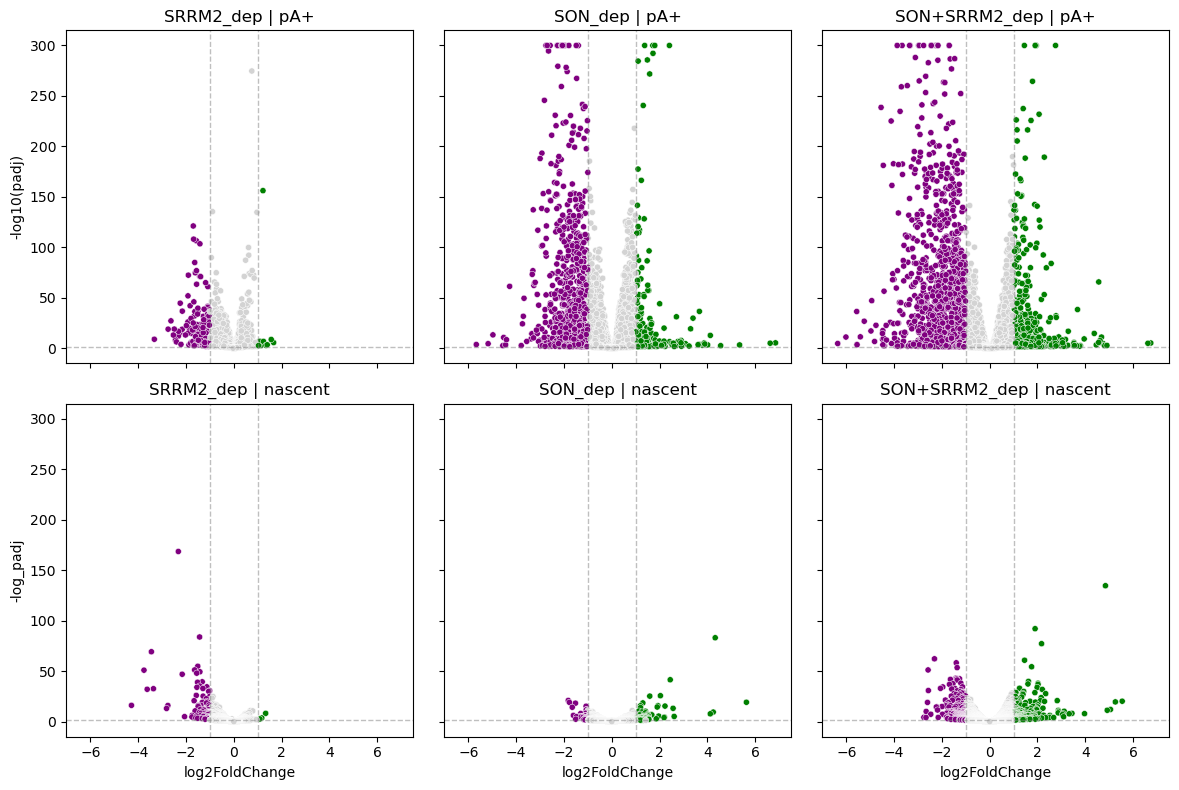

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)

palette={'DOWN':'purple', 'UP':'green', 'NC':'lightgray'}

ax1 = sns.scatterplot(data=srrm2_deseq.dropna(), 
                x='log2FoldChange', 
                y='-log_padj', 
                s = 20, 
                hue='Status',
                palette=palette,
                legend=False,
                rasterized=True,
                ax=axs[0][0])
ax2 = sns.scatterplot(data=son_deseq.dropna(), 
                x='log2FoldChange',
                y='-log_padj',  
                s = 20, 
                hue='Status',
                palette=palette,
                legend=False,
                rasterized=True,
                ax=axs[0][1])

ax3 = sns.scatterplot(data=double_deseq.dropna(), 
                x='log2FoldChange', 
                y='-log_padj', 
                s = 20, 
                hue='Status',
                palette=palette,
                legend=False,
                rasterized=True,
                ax=axs[0][2])

ax4 = sns.scatterplot(data=srrm2_deseq_4su.dropna(), 
                x='log2FoldChange', 
                y='-log_padj', 
                s = 20, 
                hue='Status',
                palette=palette,
                legend=False,
                rasterized=True,
                ax=axs[1][0])

ax5 = sns.scatterplot(data=son_deseq_4su.dropna(), 
                x='log2FoldChange',
                y='-log_padj',  
                s = 20, 
                hue='Status',
                palette=palette,
                legend=False,
                rasterized=True,
                ax=axs[1][1])

ax6 = sns.scatterplot(data=double_deseq_4su.dropna(), 
                x='log2FoldChange', 
                y='-log_padj', 
                s = 20, 
                hue='Status',
                palette=palette,
                legend=False,
                rasterized=True,
                ax=axs[1][2])


for ax in axs.flatten():
    ax.axhline(y=-np.log10(0.05), linewidth=1, color='gray', ls='--', alpha=0.5)
    ax.axvline(x=-1, linewidth=1, color='gray', ls='--', alpha=0.5)
    ax.axvline(x=1, linewidth=1, color='gray', ls='--', alpha=0.5)


ax1.set_title("SRRM2_dep | pA+")
ax2.set_title("SON_dep | pA+")
ax3.set_title("SON+SRRM2_dep | pA+")

ax4.set_title("SRRM2_dep | nascent")
ax5.set_title("SON_dep | nascent")
ax6.set_title("SON+SRRM2_dep | nascent")


ax1.set_ylabel('-log10(padj)')
plt.tight_layout()

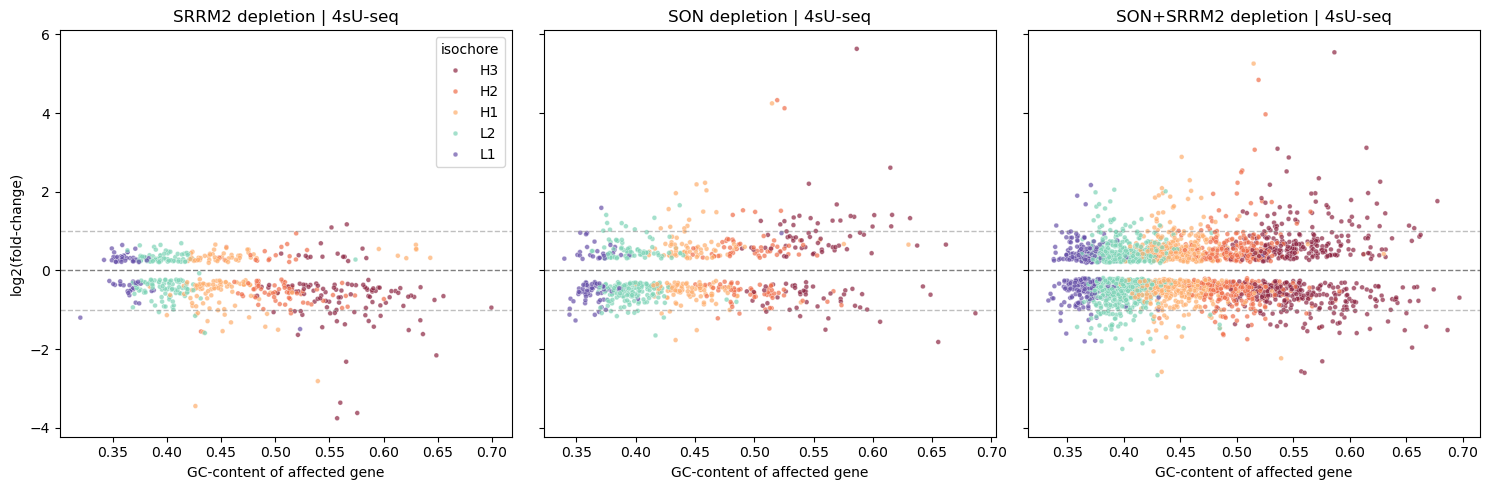

In [11]:
order = ['H3', 'H2', 'H1', 'L2', 'L1']
palette = ['#8C2542', '#F06E4A', '#FEAE6D', '#7ED4B7', '#6852A9']
color_dict = dict(zip(order, palette))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)

ax1 = sns.scatterplot(srrm2_deseq_4su_gc.dropna().query("padj < 0.05"), x='GC', y='log2FoldChange', hue='isochore', palette=color_dict, s=12, alpha=0.7, ax=axs[0], hue_order=order)
ax2 = sns.scatterplot(son_deseq_4su_gc.dropna().query("padj < 0.05"), x='GC', y='log2FoldChange', hue='isochore', palette=color_dict, s=12, alpha=0.7, ax=axs[1], legend=False, hue_order=order)
ax3 = sns.scatterplot(double_deseq_4su_gc.dropna().query("padj < 0.05"), x='GC', y='log2FoldChange', hue='isochore', palette=color_dict, s=12, alpha=0.7, ax=axs[2], legend=False, hue_order=order)

ax1.set_ylabel("log2(fold-change)")
for ax in axs:
    ax.set_xlabel("GC-content of affected gene")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=-1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
ax1.set_title("SRRM2 depletion | 4sU-seq")
ax2.set_title("SON depletion | 4sU-seq")
ax3.set_title("SON+SRRM2 depletion | 4sU-seq")

plt.tight_layout()

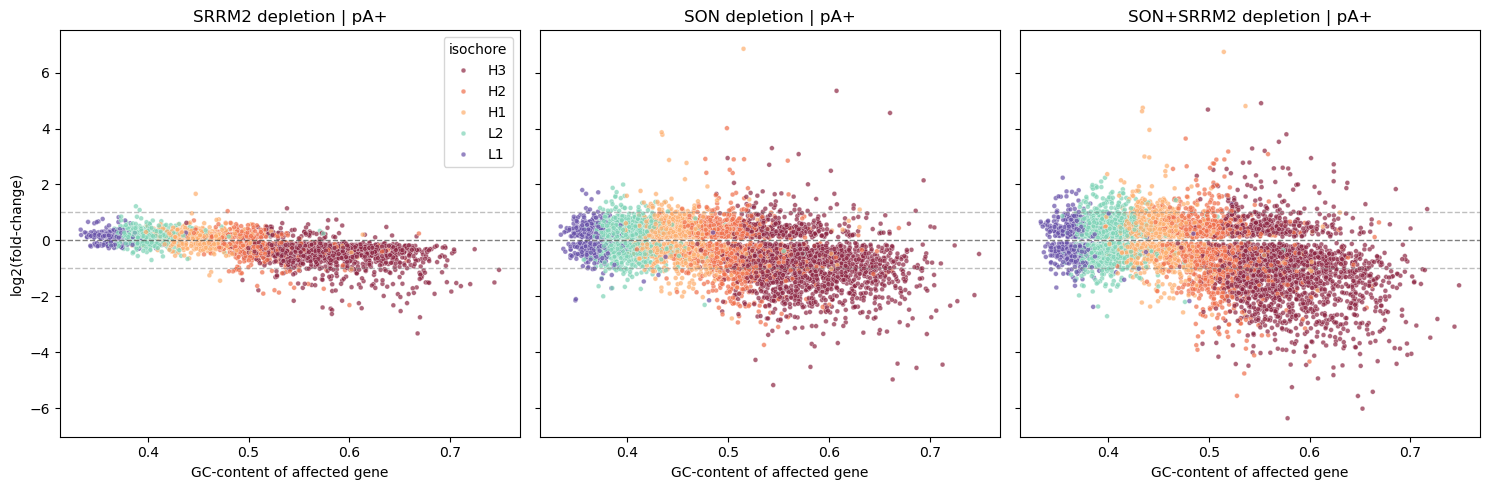

In [12]:
order = ['H3', 'H2', 'H1', 'L2', 'L1']
palette = ['#8C2542', '#F06E4A', '#FEAE6D', '#7ED4B7', '#6852A9']
color_dict = dict(zip(order, palette))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)

ax1 = sns.scatterplot(srrm2_deseq_gc.dropna().query("padj < 0.05"), x='GC', y='log2FoldChange', hue='isochore', palette=color_dict, s=12, alpha=0.7, ax=axs[0], hue_order=order)
ax2 = sns.scatterplot(son_deseq_gc.dropna().query("padj < 0.05"), x='GC', y='log2FoldChange', hue='isochore', palette=color_dict, s=12, alpha=0.7, ax=axs[1], legend=False, hue_order=order)
ax3 = sns.scatterplot(double_deseq_gc.dropna().query("padj < 0.05"), x='GC', y='log2FoldChange', hue='isochore', palette=color_dict, s=12, alpha=0.7, ax=axs[2], legend=False, hue_order=order)

ax1.set_ylabel("log2(fold-change)")
for ax in axs:
    ax.set_xlabel("GC-content of affected gene")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=-1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
ax1.set_title("SRRM2 depletion | pA+")
ax2.set_title("SON depletion | pA+")
ax3.set_title("SON+SRRM2 depletion | pA+")

plt.tight_layout()

## Radial plots (Figure 2A,B,C)

In [13]:
hg38 = bf.assembly_info("hg38")

In [14]:
# Load TSA-seq data. These are processed files from Belmont lab. They can be downloaded from https://4dnucleome.org/
path_son_tsa_seq_rep1_bf = Path("data/pre-processed/son_tsa_seq_rep1_bf.csv.gz")
path_son_tsa_seq_rep2_bf = Path("data/pre-processed/son_tsa_seq_rep2_bf.csv.gz")

if path_son_tsa_seq_rep1_bf.exists() and path_son_tsa_seq_rep2_bf.exists():
    son_tsa_seq_rep1_bf = pd.read_csv(path_son_tsa_seq_rep1_bf)
    son_tsa_seq_rep2_bf = pd.read_csv(path_son_tsa_seq_rep2_bf)
else:

    path_to_4DNFI8HIU45G = Path("/project/bigdata_aktas/hts_data/4Dnucleome/4DNFI8HIU45G.bw")
    path_to_4DNFIBY8G6RZ = Path("/project/bigdata_aktas/hts_data/4Dnucleome/4DNFIBY8G6RZ.bw")

    son_tsa_seq_rep1 = path_to_4DNFI8HIU45G
    son_tsa_seq_rep2 = path_to_4DNFIBY8G6RZ

    son_tsa_seq_rep1_bf = pd.concat([bf.read_bigwig(son_tsa_seq_rep1, chrom, engine='pyBigWig') for chrom in hg38.chromnames[:24]], axis=0)
    son_tsa_seq_rep2_bf = pd.concat([bf.read_bigwig(son_tsa_seq_rep2, chrom, engine='pyBigWig') for chrom in hg38.chromnames[:24]], axis=0)

In [15]:
# This one works with DEseq outputs

def add_speckle_distance(df, exponent=-1):
    df_copy = df.copy()

    # The ENSEMBL IDs are stored in the index, we just make a copy of them 
    # and store them in the new column 'name' 
    df_copy['name'] = df_copy.index

    # This removes the dot at the number from ENSEMBL IDs: ENSG00000277836.1 -> ENSG00000277836
    # Necessary to compare when DEseq data is from other GTFs (e.g. 4sU analysis by LM)
    df_copy['name'] = df_copy.apply(lambda row: strip_gene_id(row, 'name'), axis=1)
    
    gencodev29_gc_copy = gencodev29_gc.copy()

    # Same removal of the dot and version number from ENSEMBL IDs
    gencodev29_gc_copy['name'] = gencodev29_gc_copy.apply(lambda row: strip_gene_id(row, 'name'), axis=1)

    # This the step where we use pandas merge. The critical arguments are: on='name', 
    # which means that the merger will happen using that column
    # and how='left' means that the left dataframe (first argument, gencodev29_gc_copy)
    # has priority, if a gene name exists on the left, it will be in the merged. Entries unique to the right
    # dataframe are lost. how='right' would do the opposite.
    
    if 'log2FoldChange' in df_copy.columns:
        df_coordinates = pd.merge(gencodev29_gc_copy,
             df_copy[['name', 'log2FoldChange', 'padj']],
             on='name',
             how='left'
            )
    else:
        df_coordinates = pd.merge(gencodev29_gc_copy,
             df_copy,
             on='name',
             how='left'
            )

    # We have the dataframe df_coordinates, which has all the genes, their coordinates in the genome
    # and some other information like log2foldchange and padj from DEseq2
    # Then we have son_tsa_seq_rep1_bf, which contains the TSA-seq data, each row contains the score for
    # SON for a genomic bin (20kb bins in this case).
    # What we need is to get all the SON bins that overlap with our gene of interest, and than take the average
    # This achieved with these calls below: first the overlap is calculated with bf.overlap
    # Then we use groupby() and mean() functions to group the results by 'name', which means all the overlaps for each each is 
    # grouped, then the 'mean' of that group is reported for each 'name' --exactly what we want.
    
    overlap1 = bf.overlap(df_coordinates,son_tsa_seq_rep1_bf).groupby('name').mean('value_')
    overlap2 = bf.overlap(df_coordinates,son_tsa_seq_rep2_bf).groupby('name').mean('value_')

    # Here I merge the the results of the two overlaps with the main dataframe
    df_coordinates = pd.merge(df_coordinates,
             overlap1[['value_']].rename(columns={'value_':'SON_TSA_rep1'}),
                                    how='left',
                                    on='name'
                                   )
    df_coordinates = pd.merge(df_coordinates,
             overlap2[['value_']].rename(columns={'value_':'SON_TSA_rep2'}),
                                    how='left',
                                    on='name'
                                   )

    # I just calculate the average of two replicates, and report that.
    df_coordinates['average_dist'] = (df_coordinates.SON_TSA_rep1 + df_coordinates.SON_TSA_rep2)/2

    # The signal we get from SON inversely correlates with distance to Speckles,
    # and follows an exponential decay function of the form e^(-k*signal).
    # In the Belmont paper, the exponent k is fit to a real value by using 
    # Actual DNA-FISH data. For visualization purposes, we just use k=-1, but one can 
    # change that value while calling the function by changing the 'exponent' argument.
    
    df_coordinates['exp_SON_TSA_rep1'] = np.exp(exponent*df_coordinates.SON_TSA_rep1)
    df_coordinates['exp_SON_TSA_rep2'] = np.exp(exponent*df_coordinates.SON_TSA_rep2)
    df_coordinates['exp_average_dist'] = np.exp(exponent*df_coordinates.average_dist)
    
    return df_coordinates

In [16]:
# Add Speckle distance to DEseq dataframes

double_deseq_distances = add_speckle_distance(double_deseq)
son_deseq_distances = add_speckle_distance(son_deseq)
srrm2_deseq_distances = add_speckle_distance(srrm2_deseq)

In [17]:
# Add Speckle distance to DEseq dataframes

double_deseq_distances_4su = add_speckle_distance(double_deseq_4su.set_index('gene'))
son_deseq_distances_4su = add_speckle_distance(son_deseq_4su.set_index('gene'))
srrm2_deseq_distances_4su = add_speckle_distance(srrm2_deseq_4su.set_index('gene'))

### Radial plots of pA(+) RNA-seq data

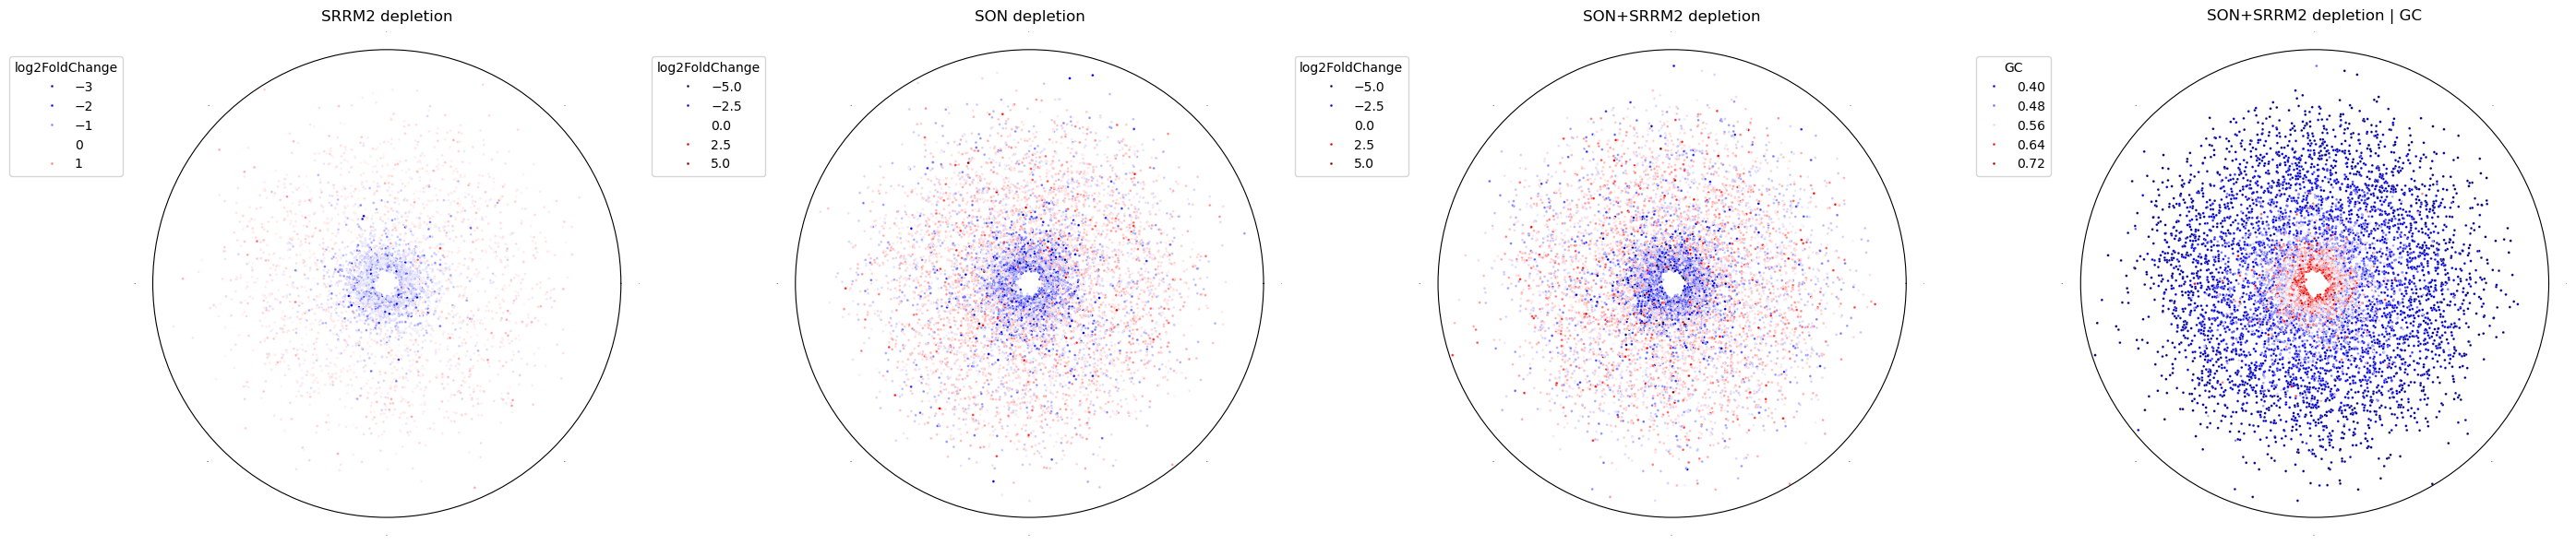

In [18]:
# Here's how we plot these
# We initialize a plot with the following line, and subplot_kw={'projection': 'polar'} creates polar coordinates

fig, axs = plt.subplots(nrows=1, ncols=4, subplot_kw={'projection': 'polar'}, figsize=[28,9])


temp1 = srrm2_deseq_distances.dropna().query("padj < 0.05")
rng1 = np.random.default_rng(seed=42)
theta1 = rng1.random(len(temp1))*2*np.pi
ax1=sns.scatterplot(x=theta1,
                    y=temp1.exp_average_dist,
                    s=4,
                    hue=temp1.log2FoldChange,
                    hue_norm=mpl.colors.TwoSlopeNorm(vmin=-4, vcenter=0,  vmax=4),
                    palette='seismic',
                    rasterized=True,
                    ax=axs[0]
               )

temp2 = son_deseq_distances.dropna().query("padj < 0.05")
rng2 = np.random.default_rng(seed=42)
theta2 = rng2.random(len(temp2))*2*np.pi
ax2=sns.scatterplot(x=theta2,
                    y=temp2.exp_average_dist,
                    s=4,
                    hue=temp2.log2FoldChange,
                    hue_norm=mpl.colors.TwoSlopeNorm(vmin=-4, vcenter=0,  vmax=4),
                    palette='seismic',
                    rasterized=True,
                    ax=axs[1]
               )

temp3 = double_deseq_distances.dropna().query("padj < 0.05")
rng3 = np.random.default_rng(seed=42)
theta3 = rng3.random(len(temp3))*2*np.pi
ax3=sns.scatterplot(x=theta3,
                    y=temp3.exp_average_dist,
                    s=4,
                    hue=temp3.log2FoldChange,
                    hue_norm=mpl.colors.TwoSlopeNorm(vmin=-4, vcenter=0,  vmax=4),
                    palette='seismic',
                    rasterized=True,
                    ax=axs[2]
               )

ax4=sns.scatterplot(x=theta3, 
                y=temp3.exp_average_dist,
               s=4,
               hue=temp3.GC,
                palette='seismic',
                    ax=axs[3]
               )

for ax in axs:
    ax.set_rticks([])  # Less radial ticks
    ax.grid(False)
    ax.set_ylabel('')
    ax.tick_params(labelsize=0, width=0)
    ax.set_rmax(2)
    sns.move_legend(ax, "upper right", bbox_to_anchor=(-0.05, 1))

ax1.set_title("SRRM2 depletion", va='bottom')
ax2.set_title("SON depletion", va='bottom')
ax3.set_title("SON+SRRM2 depletion", va='bottom')
ax4.set_title("SON+SRRM2 depletion | GC", va='bottom')
plt.tight_layout()
plt.show()

### Radial plots of 4sU RNA-seq data

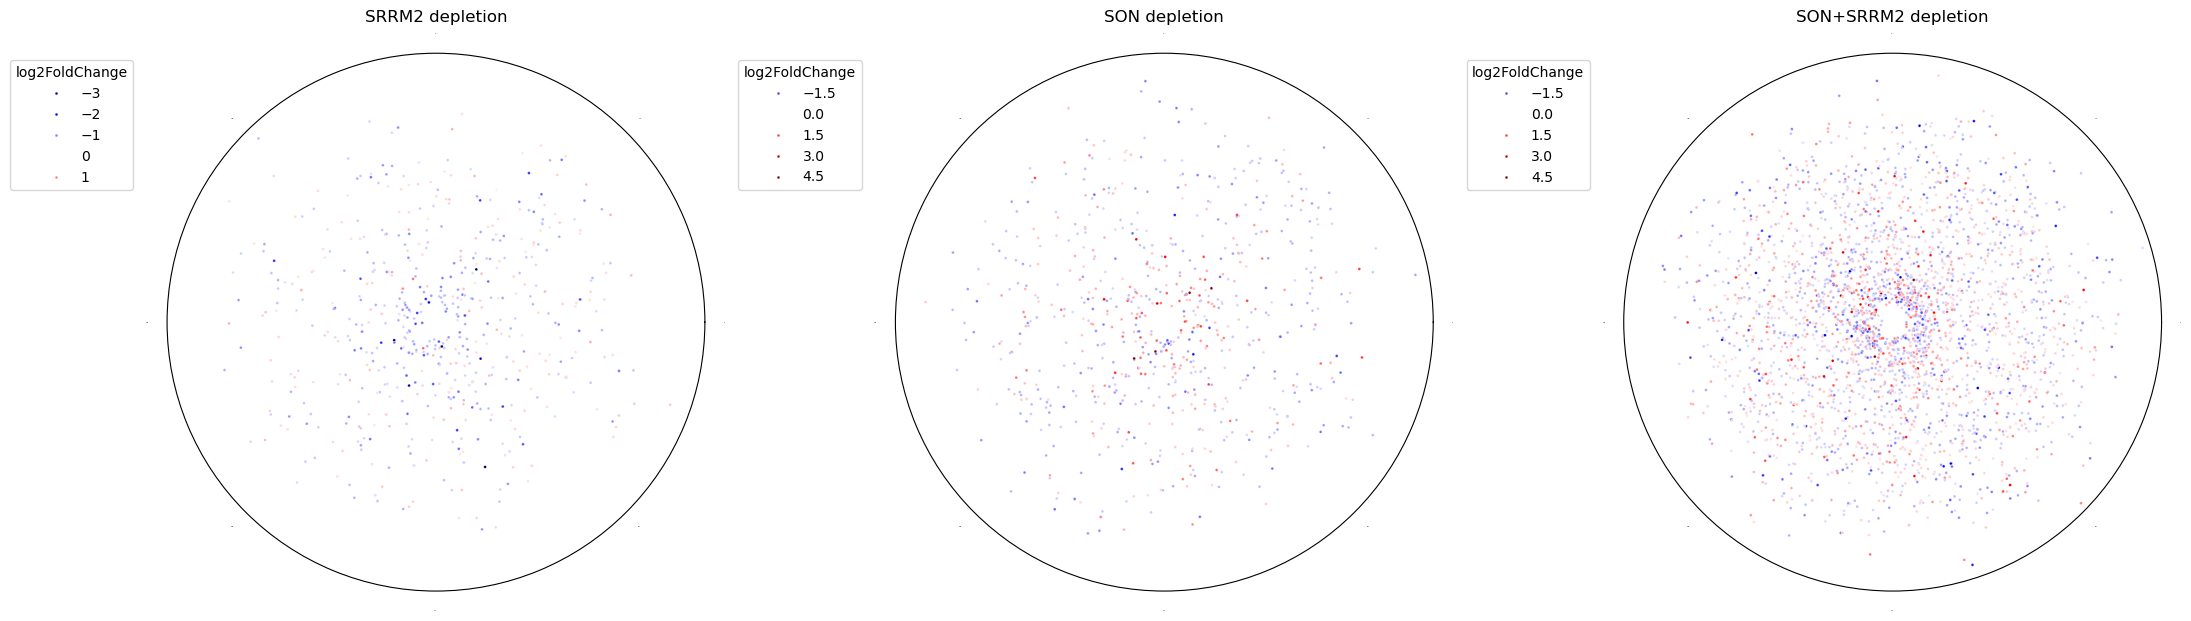

In [19]:
# Here's how we plot these
# We initialize a plot with the following line, and subplot_kw={'projection': 'polar'} creates polar coordinates

fig, axs = plt.subplots(nrows=1, ncols=3, subplot_kw={'projection': 'polar'}, figsize=[22,9])


temp1 = srrm2_deseq_distances_4su.dropna().query("padj < 0.05")
rng1 = np.random.default_rng(seed=42)
theta1 = rng1.random(len(temp1))*2*np.pi
ax1=sns.scatterplot(x=theta1,
                    y=temp1.exp_average_dist,
                    s=4,
                    hue=temp1.log2FoldChange,
                    hue_norm=mpl.colors.TwoSlopeNorm(vmin=-4, vcenter=0,  vmax=4),
                    palette='seismic',
                    rasterized=True,
                    ax=axs[0]
               )

temp2 = son_deseq_distances_4su.dropna().query("padj < 0.05")
rng2 = np.random.default_rng(seed=42)
theta2 = rng2.random(len(temp2))*2*np.pi
ax2=sns.scatterplot(x=theta2,
                    y=temp2.exp_average_dist,
                    s=4,
                    hue=temp2.log2FoldChange,
                    hue_norm=mpl.colors.TwoSlopeNorm(vmin=-4, vcenter=0,  vmax=4),
                    palette='seismic',
                    rasterized=True,
                    ax=axs[1]
               )

temp3 = double_deseq_distances_4su.dropna().query("padj < 0.05")
rng3 = np.random.default_rng(seed=42)
theta3 = rng3.random(len(temp3))*2*np.pi
ax3=sns.scatterplot(x=theta3,
                    y=temp3.exp_average_dist,
                    s=4,
                    hue=temp3.log2FoldChange,
                    hue_norm=mpl.colors.TwoSlopeNorm(vmin=-4, vcenter=0,  vmax=4),
                    palette='seismic',
                    rasterized=True,
                    ax=axs[2]
               )

for ax in axs:
    ax.set_rticks([])  # Less radial ticks
    ax.grid(False)
    ax.set_ylabel('')
    ax.tick_params(labelsize=0, width=0)
    ax.set_rmax(2)
    sns.move_legend(ax, "upper right", bbox_to_anchor=(-0.05, 1))

ax1.set_title("SRRM2 depletion", va='bottom')
ax2.set_title("SON depletion", va='bottom')
ax3.set_title("SON+SRRM2 depletion", va='bottom')
plt.tight_layout()
plt.show()